In [ ]:
!pip install wfdb --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 101.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import wfdb
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = "/content/drive/MyDrive/Stress Data/physionet.org/files/drivedb/1.0.0/"

In [ ]:
hea_paths = glob.glob(os.path.join(data_dir, "*.hea"))
dat_paths = glob.glob(os.path.join(data_dir, "*.dat"))

print("Found .hea files: ", len(hea_paths))
print("Found .dat files: ", len(dat_paths))
print("Example .hea filenames:\n", hea_paths[:3])
print("Example .dat filenames:\n", dat_paths[:3])

Found .hea files:  18
Found .dat files:  18
Example .hea filenames:
 ['/content/drive/MyDrive/Stress Data/physionet.org/files/drivedb/1.0.0/drive03.hea', '/content/drive/MyDrive/Stress Data/physionet.org/files/drivedb/1.0.0/drive02.hea', '/content/drive/MyDrive/Stress Data/physionet.org/files/drivedb/1.0.0/drive01.hea']
Example .dat filenames:
 ['/content/drive/MyDrive/Stress Data/physionet.org/files/drivedb/1.0.0/drive01.dat', '/content/drive/MyDrive/Stress Data/physionet.org/files/drivedb/1.0.0/drive02.dat', '/content/drive/MyDrive/Stress Data/physionet.org/files/drivedb/1.0.0/drive04.dat']


In [ ]:
# Check that every .hea has a matching .dat
missing = []
for hea in hea_paths:
    base = hea[:-4]            # strip off ".hea"
    if not os.path.isfile(base + ".dat"):
        missing.append(base)

if missing:
    print("\nERROR: These records have no matching .dat:")
    for m in missing:
        print("  ", m)
else:
    print("\nAll .hea files have a matching .dat file.")


All .hea files have a matching .dat file.


In [ ]:
# ── 5. TRY READING ONE RECORD ───────────────────────────────────────────────────
if not hea_paths:
    raise RuntimeError("No .hea files found in data_dir. Double-check the path.")

example_base = hea_paths[0][:-4]   # e.g., "/kaggle/input/.../record1" (without extension)
print("\nReading record:", example_base)

try:
    rec = wfdb.rdrecord(example_base)
    print("  → SUCCESS\n")
    print("  Channels:", rec.sig_name)
    print("  Sampling frequency:", rec.fs, "Hz")
    print("  Number of samples:", rec.sig_len)
    print("  Signal array shape:", rec.p_signal.shape)
except Exception as e:
    print("  → FAILED to read record:", e)
    raise


Reading record: /content/drive/MyDrive/Stress Data/physionet.org/files/drivedb/1.0.0/drive03
  → SUCCESS

  Channels: ['ECG', 'foot GSR', 'hand GSR', 'RESP']
  Sampling frequency: 31 Hz
  Number of samples: 172447
  Signal array shape: (172447, 4)


In [ ]:
# ── 6. BUILD SUMMARY STATISTICS FOR ALL RECORDS ─────────────────────────────────
records_summary = []

for hea in hea_paths:
    base = hea[:-4]
    rec = wfdb.rdrecord(base)
    sig = rec.p_signal             # shape = (n_samples, n_channels)
    names = rec.sig_name           # e.g. ["ECG", "GSR", "EMG", "Resp"]
    fs = rec.fs
    n_samples = rec.sig_len

    row = {
        "record_id": os.path.basename(base),
        "n_channels": len(names),
        "n_samples": n_samples,
        "fs_hz": fs,
        "duration_sec": n_samples / fs
    }
    # Compute mean/std/min/max for each channel
    for idx, ch in enumerate(names):
        data = sig[:, idx]
        row[f"{ch}_mean"] = np.nanmean(data)
        row[f"{ch}_std"]  = np.nanstd(data)
        row[f"{ch}_min"]  = np.nanmin(data)
        row[f"{ch}_max"]  = np.nanmax(data)

    records_summary.append(row)

df_summary = pd.DataFrame(records_summary)
print("\nSummary DataFrame created with shape:", df_summary.shape)
df_summary.head()


Summary DataFrame created with shape: (18, 37)


,record_id,n_channels,n_samples,fs_hz,duration_sec,ECG_mean,ECG_std,ECG_min,ECG_max,foot GSR_mean,...,marker_min,marker_max,EMG_mean,EMG_std,EMG_min,EMG_max,hand GSr_mean,hand GSr_std,hand GSr_min,hand GSr_max
0,drive03,4,172447,31.0,5562.806452,0.002784,0.122139,-0.450,0.857,1.477181,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,drive02,5,78056,15.5,5035.870968,-0.008236,0.497443,-9.946,9.952,1.858502,...,-4.58,132.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,drive01,6,61499,15.5,3967.677419,0.003996,0.199653,-2.483,3.188,2.890245,...,NaN,NaN,-0.005453,0.041092,-1.700,1.6901,NaN,NaN,NaN,NaN
3,drive05,7,78367,15.5,5055.935484,-0.593437,2.364201,-10.000,6.436,4.825778,...,10.73,90.61,1.246228,1.808284,-31.972,31.7820,NaN,NaN,NaN,NaN
4,drive06,7,75123,15.5,4846.645161,-0.003289,0.117594,-1.112,0.513,8.621147,...,10.01,65.61,1.090194,1.604616,-29.486,29.2540,NaN,NaN,NaN,NaN


In [ ]:
# ── 8. EDA ON SUMMARY DATAFRAME ─────────────────────────────────────────────────

# 8.1. Overview
print("\n--- DataFrame Info ---")
print(df_summary.info())

print("\n--- Descriptive Statistics (numeric columns) ---")
print(df_summary.describe().T)


--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 37 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   record_id      18 non-null     object 
 1   n_channels     18 non-null     int64  
 2   n_samples      18 non-null     int64  
 3   fs_hz          18 non-null     float64
 4   duration_sec   18 non-null     float64
 5   ECG_mean       18 non-null     float64
 6   ECG_std        18 non-null     float64
 7   ECG_min        18 non-null     float64
 8   ECG_max        18 non-null     float64
 9   foot GSR_mean  18 non-null     float64
 10  foot GSR_std   18 non-null     float64
 11  foot GSR_min   18 non-null     float64
 12  foot GSR_max   18 non-null     float64
 13  hand GSR_mean  15 non-null     float64
 14  hand GSR_std   15 non-null     float64
 15  hand GSR_min   15 non-null     float64
 16  hand GSR_max   15 non-null     float64
 17  RESP_mean      18 non-null     f

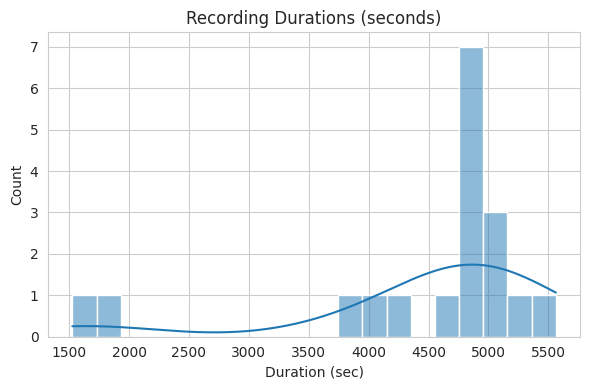

In [ ]:
# 8.2. Distribution of recording durations
plt.figure(figsize=(6,4))
sns.histplot(df_summary["duration_sec"], bins=20, kde=True)
plt.title("Recording Durations (seconds)")
plt.xlabel("Duration (sec)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


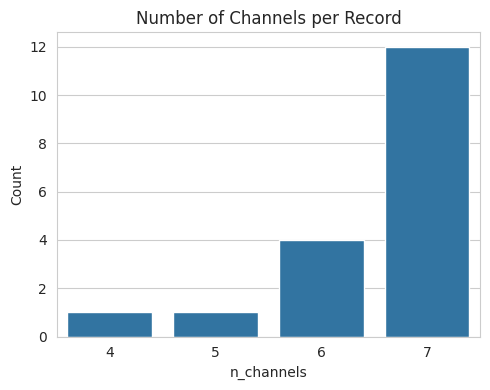

In [ ]:

# 8.3. Countplot: how many channels each record has
plt.figure(figsize=(5,4))
sns.countplot(x="n_channels", data=df_summary)
plt.title("Number of Channels per Record")
plt.xlabel("n_channels")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

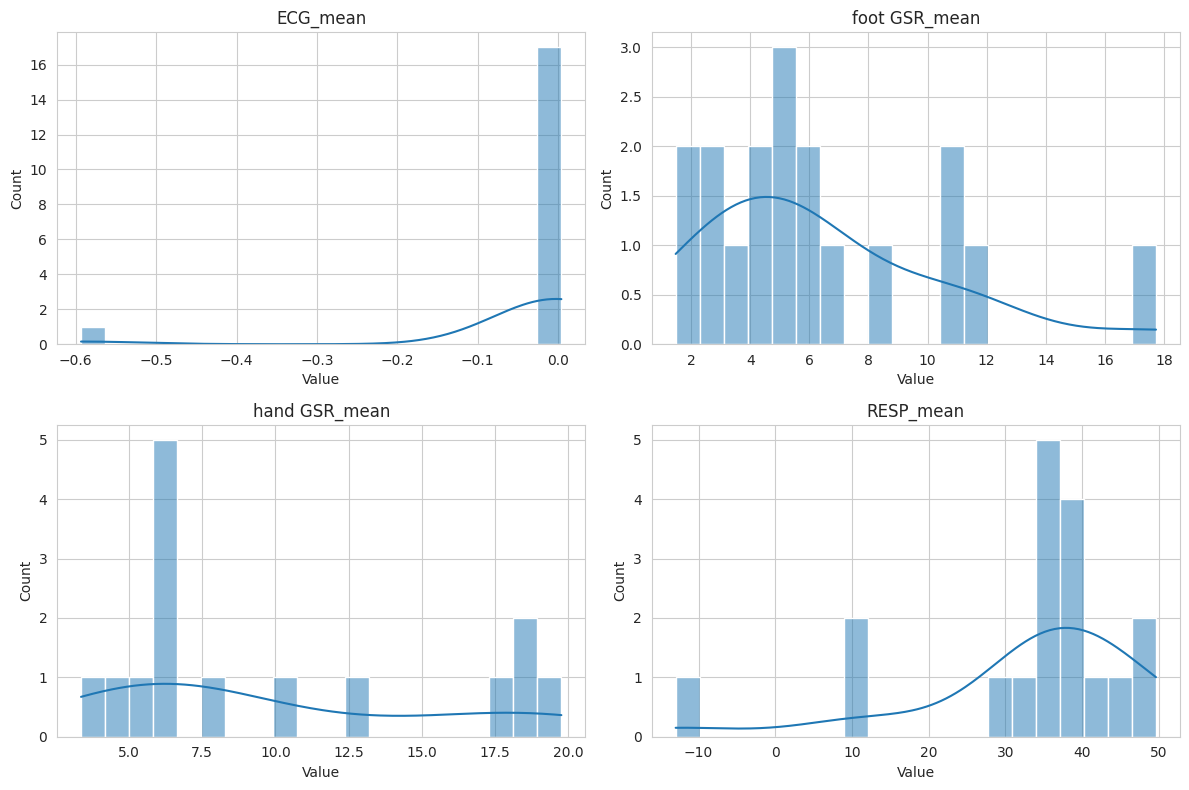

In [ ]:
# 8.4. Histograms of channel means (pick first 4 channels found)
chan_mean_cols = [c for c in df_summary.columns if c.endswith("_mean")]
sample_means = chan_mean_cols[:4]

plt.figure(figsize=(12, 8))
for i, col in enumerate(sample_means, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df_summary[col], bins=20, kde=True)
    plt.title(col)
    plt.xlabel("Value")
plt.tight_layout()
plt.show()

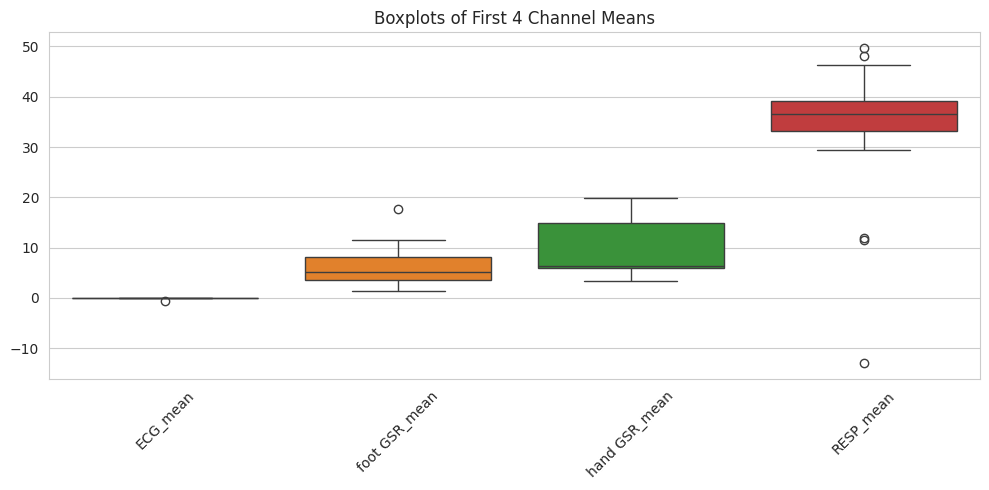

In [ ]:
# 8.5. Boxplots of those same channel means
plt.figure(figsize=(10,5))
sns.boxplot(data=df_summary[sample_means])
plt.title("Boxplots of First 4 Channel Means")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

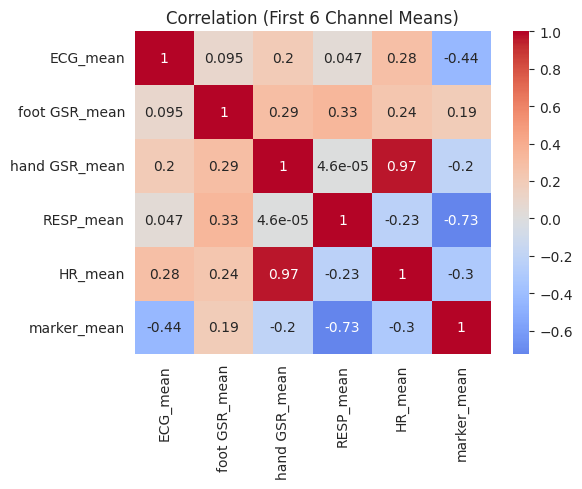

In [ ]:
# 8.6. Correlation heatmap (first 6 channel means)
if len(chan_mean_cols) >= 6:
    corr_sub = df_summary[chan_mean_cols[:6]].corr()
    plt.figure(figsize=(6,5))
    sns.heatmap(corr_sub, annot=True, cmap="coolwarm", center=0)
    plt.title("Correlation (First 6 Channel Means)")
    plt.tight_layout()
    plt.show()

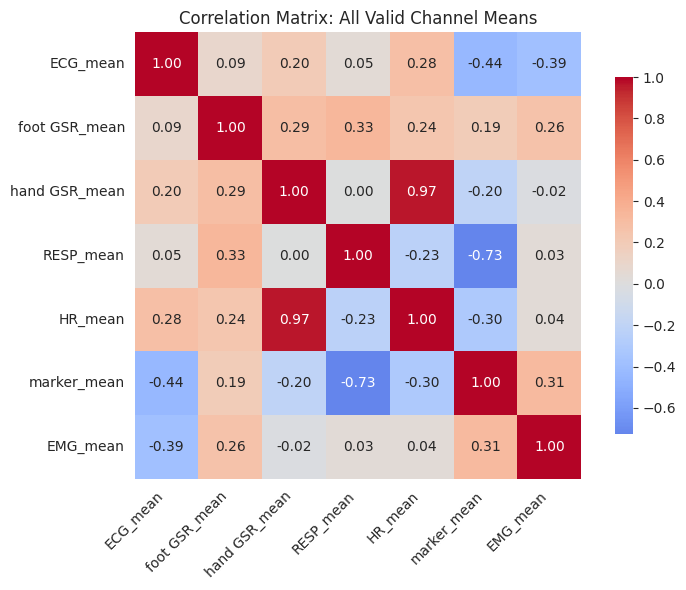

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Identify all “_mean” columns
chan_mean_cols = [col for col in df_summary.columns if col.endswith("_mean")]

# 2. Filter out any “_mean” columns with fewer than 2 non-null values
valid_means = [
    c for c in chan_mean_cols
    if df_summary[c].notnull().sum() >= 2
]

# 3. Further drop any column that is constant (only one unique non-null value),
#    since its correlation with others will be NaN
valid_means = [
    c for c in valid_means
    if df_summary[c].nunique(dropna=True) > 1
]

# 4. Extract only those columns for correlation
corr_df = df_summary[valid_means]

# 5. Compute the correlation matrix (pairwise, ignoring NaNs)
corr_matrix = corr_df.corr()

# 6. Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    cbar_kws={"shrink": .8},
    square=True
)
plt.title("Correlation Matrix: All Valid Channel Means")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. Prepare DataFrame of all valid "_mean" columns and drop rows with NaN in them
all_means = valid_means  # from the step above
pca_df = df_summary[all_means].dropna()

# 2. Corresponding labels
labels = df_summary.loc[pca_df.index, "stress_label"].map({0: "No Stress", 1: "Stress"})

# 3. Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(pca_df)

# 4. Fit PCA to 2 components
pca = PCA(n_components=2)
pcs = pca.fit_transform(X_scaled)

# 5. Build a small DataFrame for plotting
pca_plot_df = pd.DataFrame({
    "PC1": pcs[:, 0],
    "PC2": pcs[:, 1],
    "StressLabel": labels
})

# 6. Plot PC1 vs. PC2
plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=pca_plot_df,
    x="PC1",
    y="PC2",
    hue="StressLabel",
    palette={"No Stress": "skyblue", "Stress": "salmon"},
    s=60,
    alpha=0.7
)
plt.title("PCA of All Channel Means (2 Components)")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.legend(title="", loc="best")
plt.tight_layout()
plt.show()


KeyError: 'stress_label'

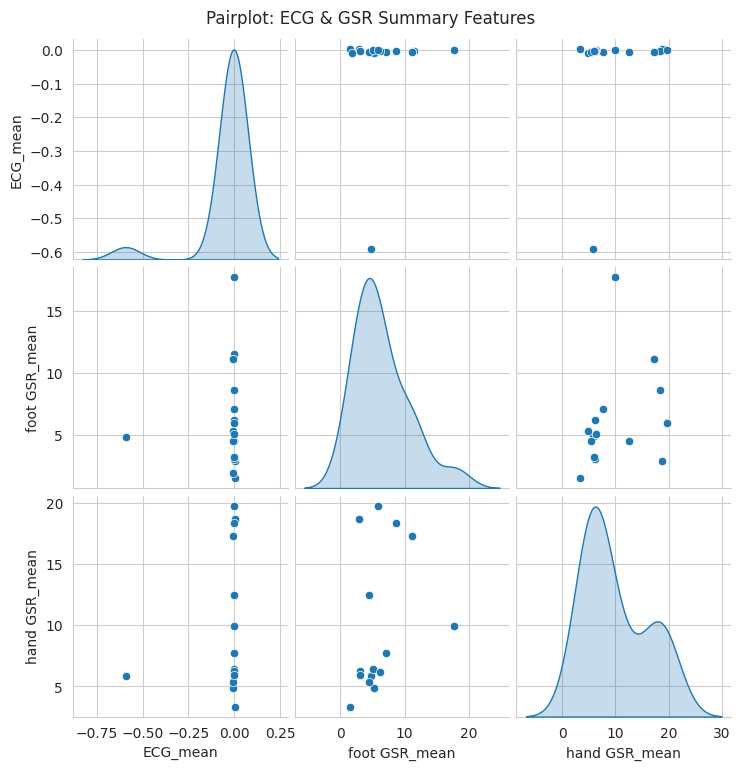

In [ ]:
# 8.7. Pairplot for ECG & GSR summary stats, if present
plot_cols = [c for c in chan_mean_cols if "ECG_mean" in c or "GSR_mean" in c or "ECG_std" in c or "GSR_std" in c]
if len(plot_cols) >= 2:
    sns.pairplot(df_summary[plot_cols], diag_kind="kde")
    plt.suptitle("Pairplot: ECG & GSR Summary Features", y=1.02)
    plt.show()
else:
    print("\nPairplot skipped: 'ECG' or 'GSR' not found among summary columns.")


In [ ]:
# ── 9. SIGNAL‐LEVEL VISUALIZATION FOR ONE EXAMPLE RECORD ─────────────────────────
example_base = hea_paths[0][:-4]
rec = wfdb.rdrecord(example_base)
sig = rec.p_signal      # (n_samples, n_channels)
names = rec.sig_name
fs = rec.fs

print(f"\nExample Record: {os.path.basename(example_base)}")
print("Channels:", names)
print("Sampling frequency:", fs, "Hz")
print("Signal shape (samples x channels):", sig.shape)


Example Record: drive03
Channels: ['ECG', 'foot GSR', 'hand GSR', 'RESP']
Sampling frequency: 31 Hz
Signal shape (samples x channels): (172447, 4)


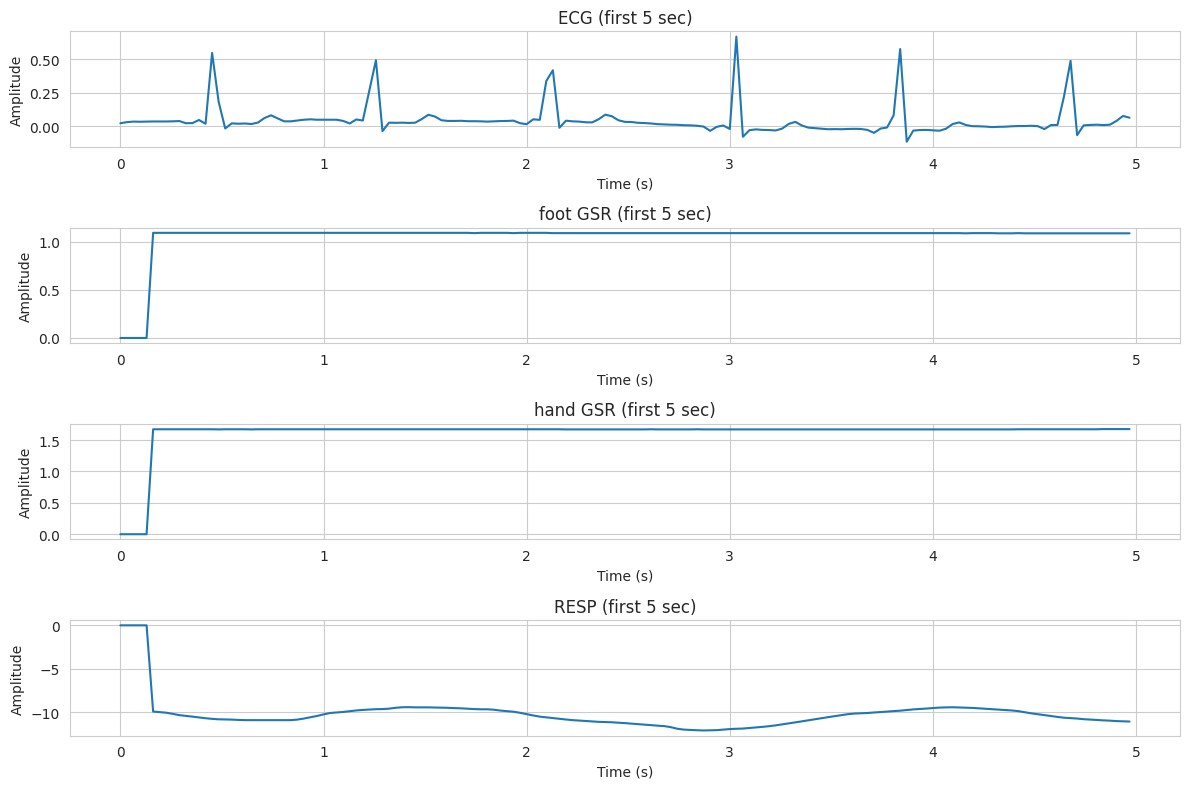

In [ ]:
# Plot first 5 seconds of up to 5 channels
plot_time = 5  # seconds
n_samp_plot = int(plot_time * fs)
n_ch_plot = min(len(names), 5)
t_axis = np.arange(n_samp_plot) / fs

plt.figure(figsize=(12, 2 * n_ch_plot))
for i in range(n_ch_plot):
    plt.subplot(n_ch_plot, 1, i+1)
    plt.plot(t_axis, sig[:n_samp_plot, i])
    plt.title(f"{names[i]} (first {plot_time} sec)")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
plt.show()

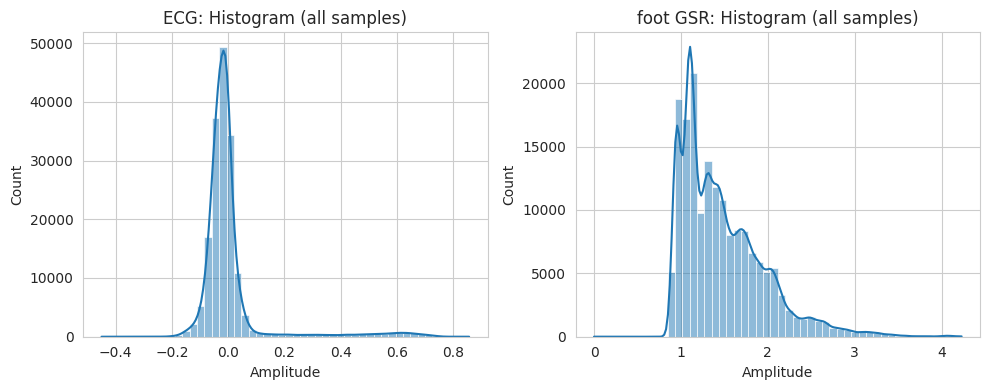

In [ ]:
# Plot histograms of two channels (if at least two exist)
if sig.shape[1] >= 2:
    plt.figure(figsize=(10,4))
    for i, ch_idx in enumerate([0,1], start=1):
        plt.subplot(1, 2, i)
        sns.histplot(sig[:, ch_idx], bins=50, kde=True)
        plt.title(f"{names[ch_idx]}: Histogram (all samples)")
        plt.xlabel("Amplitude")
    plt.tight_layout()
    plt.show()

In [ ]:
# ── 10. OPTIONAL: IF .atr ANNOTATIONS EXIST, VISUALIZE THEM ─────────────────────
ann_paths = glob.glob(os.path.join(data_dir, "*.atr"))
if ann_paths:
    ann_base = ann_paths[0][:-4]
    annotation = wfdb.rdann(ann_base, extension="atr")
    print("\nAnnotation for:", ann_base)
    print("First 10 annotation sample indices:", annotation.sample[:10])
    print("First 10 annotation symbols:", annotation.symbol[:10])

    # Overlay R-peak markers on the ECG channel (assume it’s channel 0)
    ecg_channel = 0
    samples_to_plot = 1000
    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(sig[:samples_to_plot, ecg_channel], label="ECG (first 1000 samples)")
    ann_samples = annotation.sample
    ann_samples = ann_samples[ann_samples < samples_to_plot]
    ax.scatter(ann_samples, sig[ann_samples, ecg_channel], color="red", s=20, label="Annotations")
    ax.set_title("ECG + Beat Annotations (first 1000 samples)")
    ax.set_xlabel("Sample Index")
    ax.set_ylabel("Amplitude")
    ax.legend()
    plt.tight_layout()
    plt.show()
else:
    print("\nNo .atr annotation files found; skipping annotation plot.")


No .atr annotation files found; skipping annotation plot.


In [ ]:
# ── 11. PRINT A CONCISE EDA SUMMARY ───────────────────────────────────────────────
print("\n── EDA SUMMARY ───────────────────────────────────────────")
print("Records processed:", len(hea_paths))
print("Summary columns:\n", df_summary.columns.tolist())
print("\nDuration summary (sec):\n", df_summary["duration_sec"].describe())
print("\nChannel counts:\n", df_summary["n_channels"].value_counts())
print("────────────────────────────────────────────────────────────")


── EDA SUMMARY ───────────────────────────────────────────
Records processed: 18
Summary columns:
 ['record_id', 'n_channels', 'n_samples', 'fs_hz', 'duration_sec', 'ECG_mean', 'ECG_std', 'ECG_min', 'ECG_max', 'foot GSR_mean', 'foot GSR_std', 'foot GSR_min', 'foot GSR_max', 'hand GSR_mean', 'hand GSR_std', 'hand GSR_min', 'hand GSR_max', 'RESP_mean', 'RESP_std', 'RESP_min', 'RESP_max', 'HR_mean', 'HR_std', 'HR_min', 'HR_max', 'marker_mean', 'marker_std', 'marker_min', 'marker_max', 'EMG_mean', 'EMG_std', 'EMG_min', 'EMG_max', 'hand GSr_mean', 'hand GSr_std', 'hand GSr_min', 'hand GSr_max']

Duration summary (sec):
 count      18.000000
mean     4447.084468
std      1103.311625
min      1526.129032
25%      4353.951613
50%      4859.096774
75%      4968.338710
max      5562.806452
Name: duration_sec, dtype: float64

Channel counts:
 n_channels
7    12
6     4
5     1
4     1
Name: count, dtype: int64
────────────────────────────────────────────────────────────


<ipython-input-27-4230cf025cbb>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


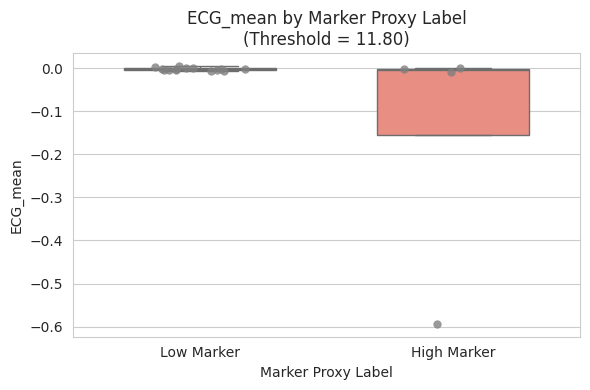

<ipython-input-27-4230cf025cbb>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


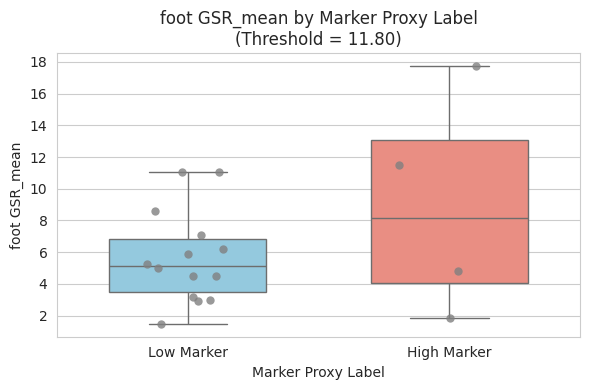

<ipython-input-27-4230cf025cbb>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


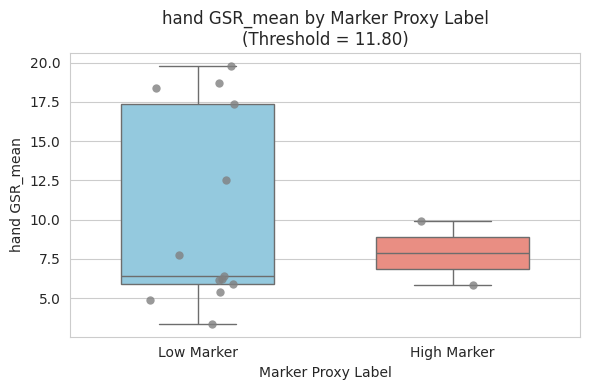

<ipython-input-27-4230cf025cbb>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


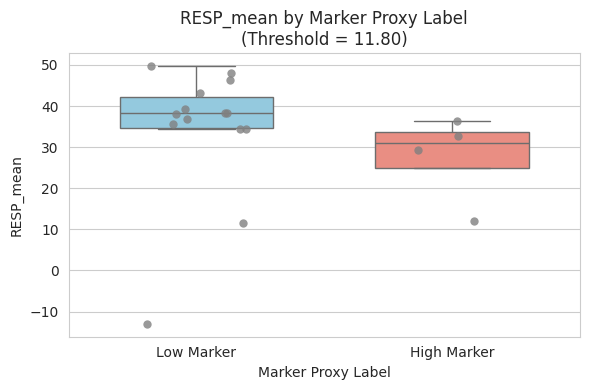

<ipython-input-27-4230cf025cbb>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


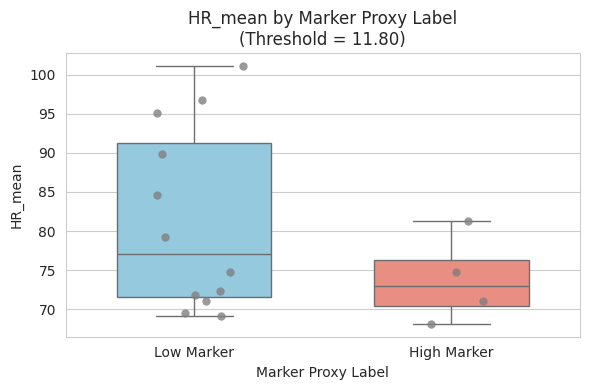

<ipython-input-27-4230cf025cbb>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


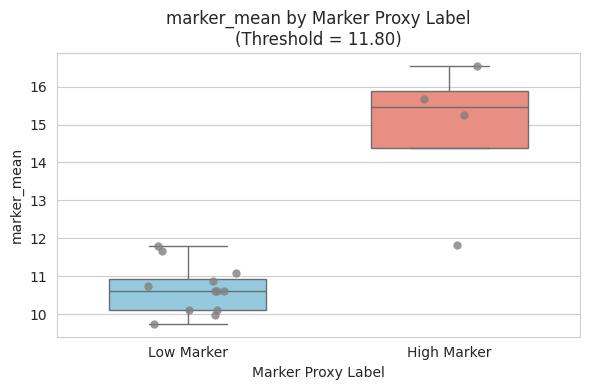

<ipython-input-27-4230cf025cbb>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


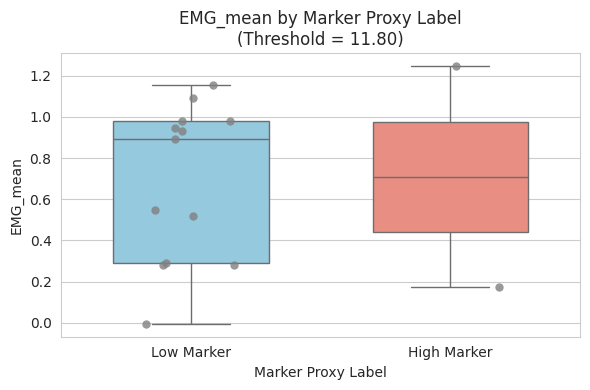

<ipython-input-27-4230cf025cbb>:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
<ipython-input-27-4230cf025cbb>:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


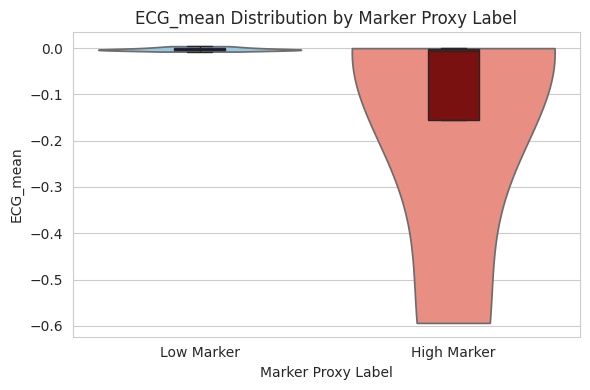

<ipython-input-27-4230cf025cbb>:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
<ipython-input-27-4230cf025cbb>:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


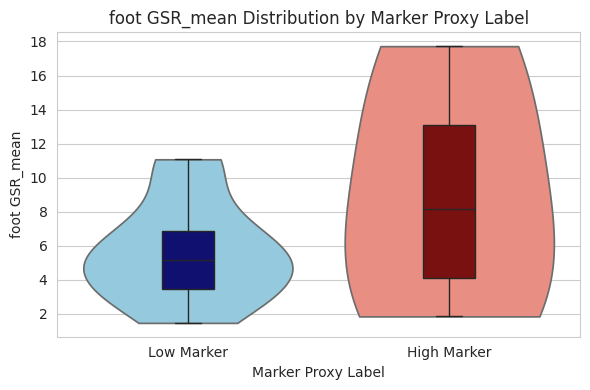

<ipython-input-27-4230cf025cbb>:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
<ipython-input-27-4230cf025cbb>:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


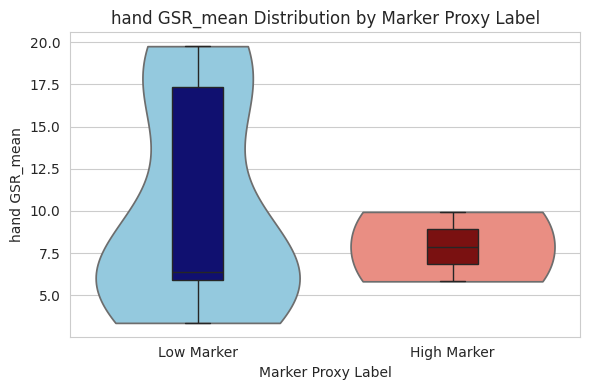

<ipython-input-27-4230cf025cbb>:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
<ipython-input-27-4230cf025cbb>:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


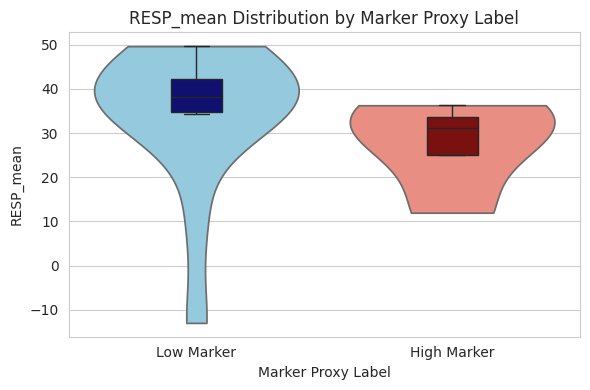

<ipython-input-27-4230cf025cbb>:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
<ipython-input-27-4230cf025cbb>:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


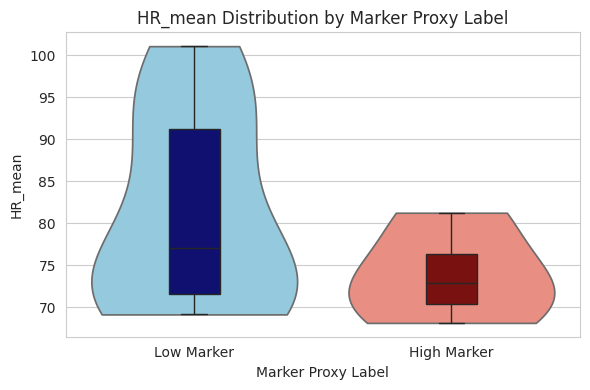

<ipython-input-27-4230cf025cbb>:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
<ipython-input-27-4230cf025cbb>:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


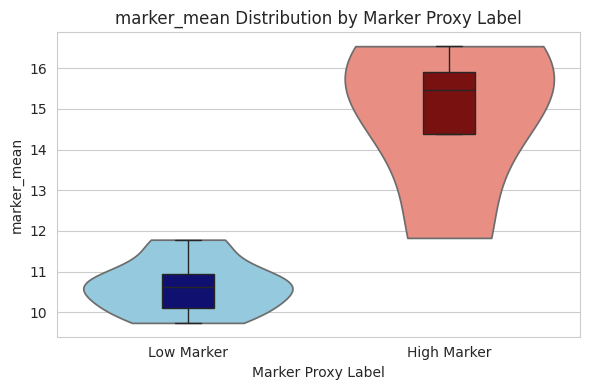

<ipython-input-27-4230cf025cbb>:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
<ipython-input-27-4230cf025cbb>:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


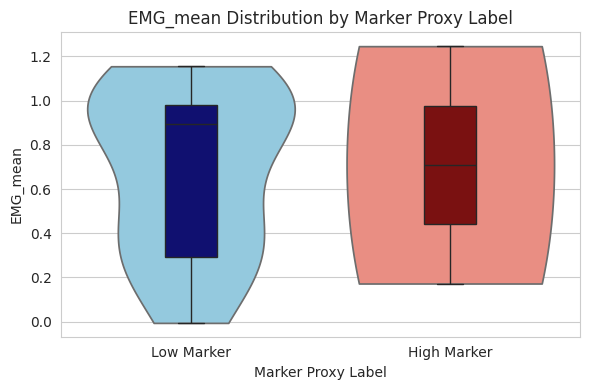

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ── STEP 1: Build a “marker_label” as a proxy for stress ───────────────────
# (Only do this once—skip if you already have marker_label)
# We’ll threshold marker_mean at its 75th percentile for “high‐marker” sessions.
threshold = df_summary["marker_mean"].quantile(0.75)
df_summary["marker_label"] = np.where(
    df_summary["marker_mean"] >= threshold, 1, 0
)
# Now 0 = low‐marker (likely lower‐stress proxy), 1 = high‐marker (likely higher‐stress proxy)

# ── STEP 2: Select your channel‐mean columns ────────────────────────────────
# Exclude any “hand GSr_mean” (only one non-null) and ensure at least 2 non-null entries
chan_mean_cols = [c for c in df_summary.columns if c.endswith("_mean")]
valid_means = [
    c for c in chan_mean_cols
    if df_summary[c].notnull().sum() >= 2 and df_summary[c].nunique(dropna=True) > 1
]
# For clarity, you might reorder or pick a subset; here we’ll use all valid_means

# ── STEP 3: Boxplot + Stripplot by marker_label ─────────────────────────────
for col in valid_means:
    plt.figure(figsize=(6,4))
    # Draw boxplot split by marker_label
    sns.boxplot(
        x="marker_label",
        y=col,
        data=df_summary,
        palette=["skyblue","salmon"],
        width=0.6,
        fliersize=0  # hide the default outlier points so stripplot is clearer
    )
    # Overlay with stripplot (jittered points) so we see every session
    sns.stripplot(
        x="marker_label",
        y=col,
        data=df_summary,
        color="gray",
        size=6,
        jitter=0.2,
        alpha=0.8
    )
    plt.xlabel("Marker Proxy Label")
    plt.xticks([0,1], ["Low Marker","High Marker"])
    plt.ylabel(col)
    plt.title(f"{col} by Marker Proxy Label\n(Threshold = {threshold:.2f})")
    plt.tight_layout()
    plt.show()

# ── STEP 4: Violin + Boxplot Combo ───────────────────────────────────────────
# (Violin shows the full distribution shape; box inside shows median & IQR)
for col in valid_means:
    plt.figure(figsize=(6,4))
    sns.violinplot(
        x="marker_label",
        y=col,
        data=df_summary,
        palette=["skyblue","salmon"],
        inner=None,  # hide the default “inner” bars so boxplot inside is clear
        cut=0        # no extended tails beyond data
    )
    sns.boxplot(
        x="marker_label",
        y=col,
        data=df_summary,
        width=0.2,
        palette=["navy","darkred"],
        fliersize=0
    )
    plt.xlabel("Marker Proxy Label")
    plt.xticks([0,1], ["Low Marker","High Marker"])
    plt.ylabel(col)
    plt.title(f"{col} Distribution by Marker Proxy Label")
    plt.tight_layout()
    plt.show()


<ipython-input-28-109fd4ff2acf>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
<ipython-input-28-109fd4ff2acf>:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Low", "High"])
<ipython-input-28-109fd4ff2acf>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
<ipython-input-28-109fd4ff2acf>:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Low", "High"])
<ipython-input-28-109fd4ff2acf>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed

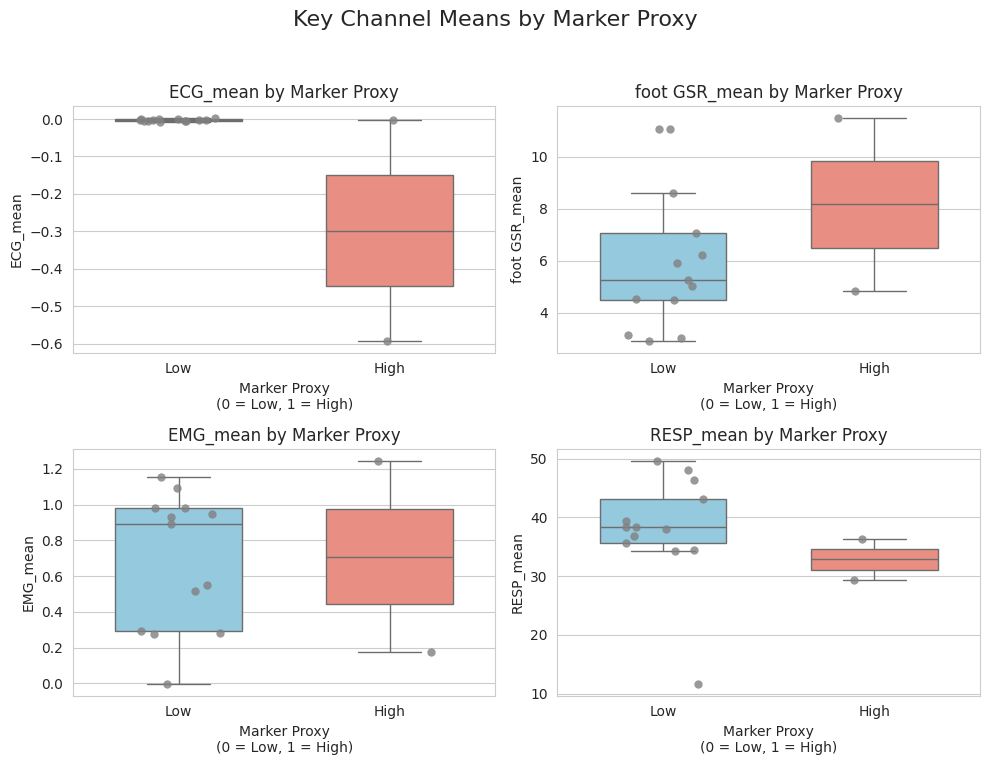

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Create a “marker_label” as a stress proxy (top 25% of marker_mean = high marker)
threshold = df_summary["marker_mean"].quantile(0.75)
df_summary["marker_label"] = np.where(df_summary["marker_mean"] >= threshold, 1, 0)

# 2. Select four key channel-mean columns for the slide
selected_means = ["ECG_mean", "foot GSR_mean", "EMG_mean", "RESP_mean"]

# 3. Drop any sessions missing those values
plot_df = df_summary[selected_means + ["marker_label"]].dropna()

# 4. Plot a 2×2 grid of boxplot + stripplot for each selected channel mean
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for ax, col in zip(axes, selected_means):
    sns.boxplot(
        x="marker_label",
        y=col,
        data=plot_df,
        palette=["skyblue", "salmon"],
        width=0.6,
        ax=ax,
        fliersize=0
    )
    sns.stripplot(
        x="marker_label",
        y=col,
        data=plot_df,
        color="gray",
        size=6,
        jitter=0.2,
        alpha=0.8,
        ax=ax
    )
    ax.set_xlabel("Marker Proxy\n(0 = Low, 1 = High)")
    ax.set_xticklabels(["Low", "High"])
    ax.set_ylabel(col)
    ax.set_title(f"{col} by Marker Proxy")

fig.suptitle("Key Channel Means by Marker Proxy", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
